# Riparian organic and mineral soil WEP in response to grazing

Alex Koiter

## Load Libraries

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Warning in checkDepPackageVersion(dep_pkg = "TMB"): Package version inconsistency detected.
glmmTMB was built with TMB version 1.9.6
Current TMB version is 1.9.9
Please re-install glmmTMB from source or restore original 'TMB' package (see '?reinstalling' for more information)

This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

## Read in clean data

In [ ]:
conc <- read_csv(here::here("notebooks/Data/P_concentration.csv")) %>%
  rename("conc" = "ak_content")


Rows: 1141 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_type, timing, plot, location, treatment
dbl (3): site, ak_content, year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Organics data

In [ ]:
organic_diff <- conc %>%
  filter(sample_type == "Organic") %>%
  pivot_wider(names_from = timing, values_from = conc) %>%
  mutate(diff = Before - After) %>%
  mutate(treatment = fct_recode(treatment, "Graze" = "Regular Graze")) %>%
  mutate(treatment = fct_relevel(treatment, c("Control", "Graze", "High Graze", "Mow"))) %>%
  mutate(location = fct_relevel(location, c("Upper", "Middle", "Lower")))


## Soil data

In [ ]:
soil_diff <- conc %>%
  filter(sample_type == "Soil") %>%
  pivot_wider(names_from = timing, values_from = conc) %>%
  mutate(diff = Before - After) %>%
  mutate(treatment = fct_recode(treatment, "Graze" = "Regular Graze")) %>%
  mutate(treatment = fct_relevel(treatment, c("Control", "Graze", "High Graze", "Mow"))) %>%
  mutate(location = fct_relevel(location, c("Upper", "Middle", "Lower")))


## Organics analysis

In [ ]:
m7 <- glmmTMB(diff ~ treatment * location + (1|site) + (1|year),
              data = organic_diff)


Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.238 0.027 0.226 0.24 0.719 0.392 0.179 0.09 0.368 0.246 0.39 0.748 0.864 0.689 0.362 0.796 0.846 0.507 0.995 0.711 ...

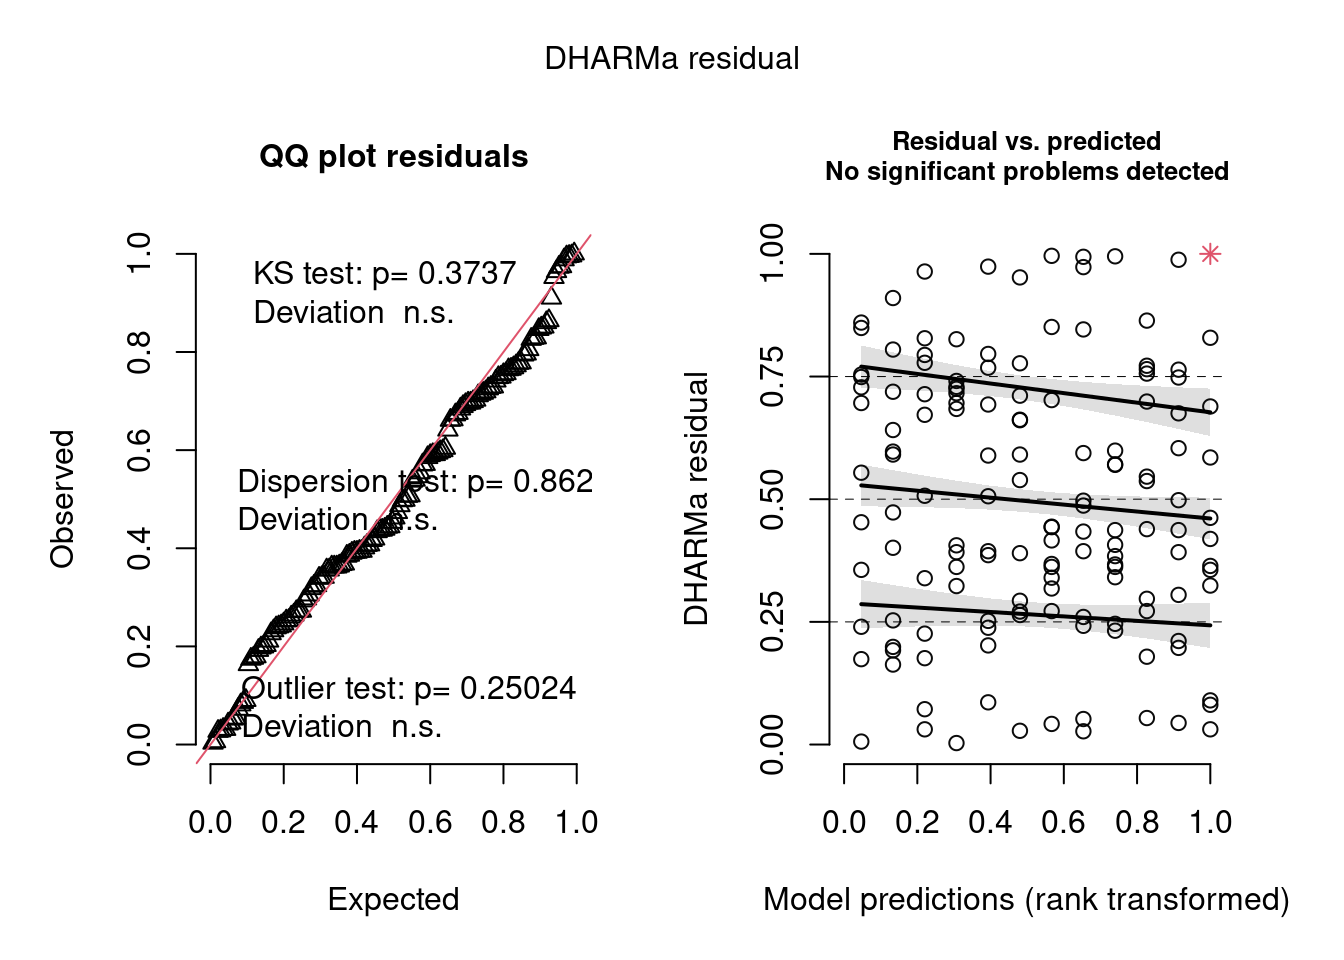

In [ ]:
simulateResiduals(m7, n = 1000, plot = TRUE)


In [ ]:
car::Anova(m7, type = "III")  # No interaction


Analysis of Deviance Table (Type III Wald chisquare tests)

Response: diff
                    Chisq Df Pr(>Chisq)
(Intercept)        0.0818  1     0.7748
treatment          3.4925  3     0.3217
location           0.4320  2     0.8057
treatment:location 2.8110  6     0.8322

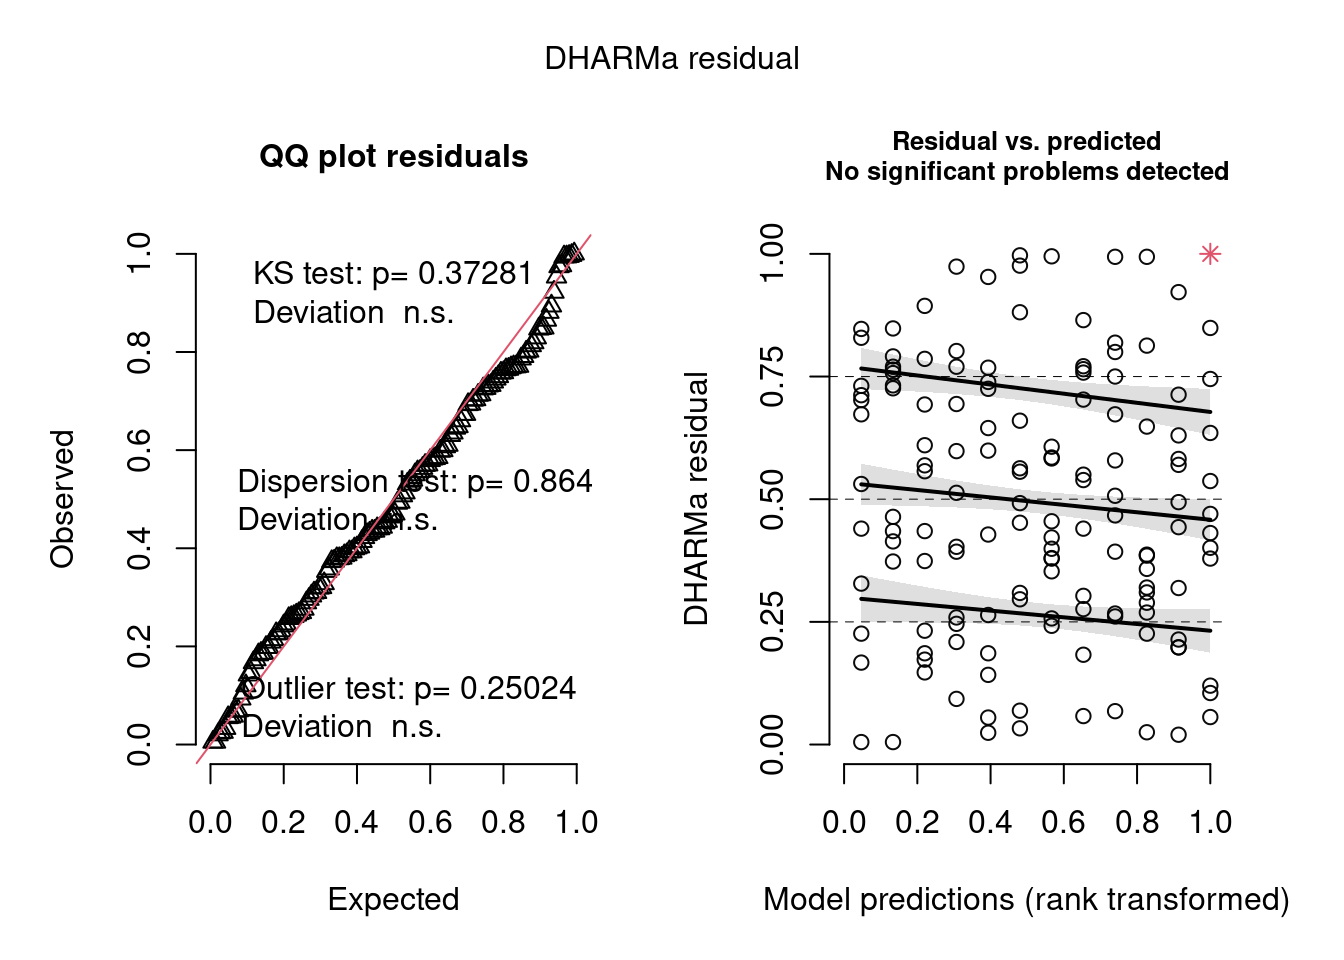

Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.246 0.033 0.186 0.226 0.693 0.435 0.183 0.12 0.31 0.257 0.319 0.8 0.865 0.745 0.32 0.802 0.881 0.428 0.995 0.63 ...

# Check for Multicollinearity

Low Correlation

      Term  VIF      VIF  CI Increased SE Tolerance
 treatment 1.00 [1.00, 1.00]         1.00      1.00
  location 1.00 [1.00, 1.00]         1.00      1.00

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: diff
             Chisq Df Pr(>Chisq)  
(Intercept) 0.9723  1    0.32411  
treatment   8.2398  3    0.04131 *
location    0.5743  2    0.75039  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [ ]:
m7 <- glmmTMB(diff ~ treatment + location + (1|site) + (1|year),
              data = organic_diff)
simulateResiduals(m7, n = 1000, plot = TRUE) # No interaction


Post-hoc

In [ ]:
m_emms7 <- emmeans(m7, ~treatment)
pairs(m_emms7, adjust = "fdr")


 contrast             estimate    SE  df t.ratio p.value
 Control - Graze        -1.486 0.594 135  -2.501  0.0656
 Control - High Graze   -0.625 0.594 135  -1.052  0.3534
 Control - Mow          -1.378 0.594 135  -2.319  0.0656
 Graze - High Graze      0.861 0.594 135   1.449  0.2994
 Graze - Mow             0.108 0.594 135   0.182  0.8560
 High Graze - Mow       -0.753 0.594 135  -1.267  0.3110

Results are averaged over the levels of: location 
P value adjustment: fdr method for 6 tests 

### Plots

Extra

In [ ]:
df <- data.frame(x1 = c(-Inf, -Inf), x2 = c(Inf, Inf), y2 = c(Inf, 0), y1 = c(0, -Inf), difference = c("Net removal", "Net addition")) %>%
  mutate(difference = fct_relevel(difference, c("Net removal", "Net addition"))) 


Plots

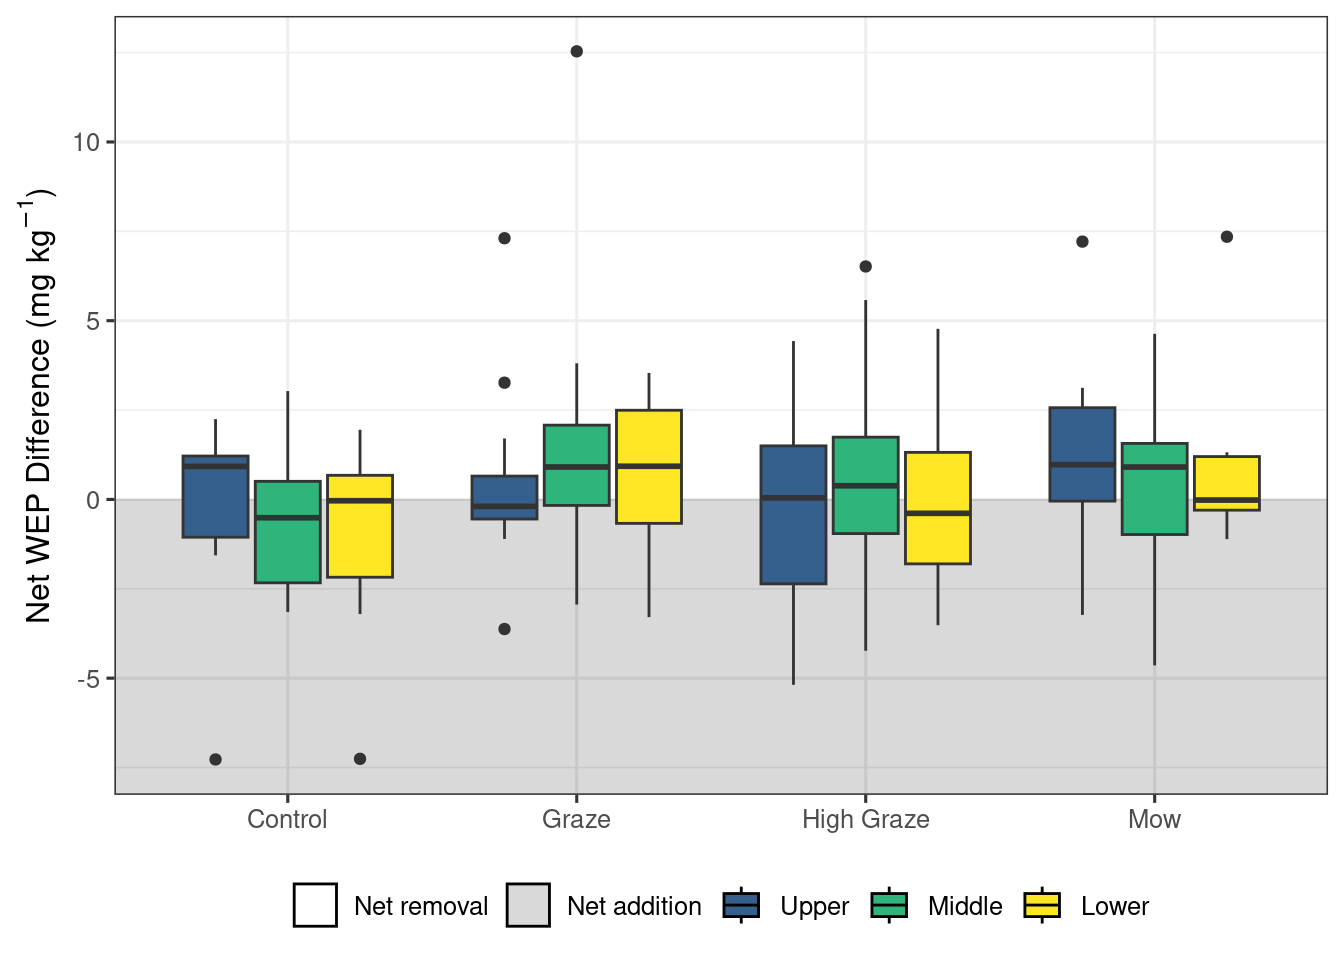

In [ ]:
#|
p1 <- ggplot(data = organic_diff) +
  theme_bw(base_size = 12) + 
  geom_rect(data = df, aes(xmin = x1, xmax = x2, ymin = y1, ymax = y2, fill = difference), alpha = 0.15) +
  #scale_fill_manual(values = c("white", "black")) +
  #ggnewscale::new_scale_fill() +
  geom_boxplot(aes(x = treatment, y = diff, fill = location)) +
  #scale_fill_viridis_d(name = "Location", begin = 0.3, end = 1) +
  scale_fill_manual(values = c("white", "black", "#35608DFF", "#2FB47CFF", "#FDE725FF")) +
  guides(fill = guide_legend(override.aes = list(colour = "black", size = 1))) +
  labs(y = expression(paste("Net WEP Difference (", mg~kg^{-1}, ")")), x = "Treatment") +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 0, vjust = 1, hjust = 0.5),
        legend.position = 'bottom', legend.title = element_blank())
p1
#ggsave(plot = p1, filename = "Figures/Organics_WEP.png", width = 150, height = 100, units = "mm", dpi = 600)


## Mineral soil analysis

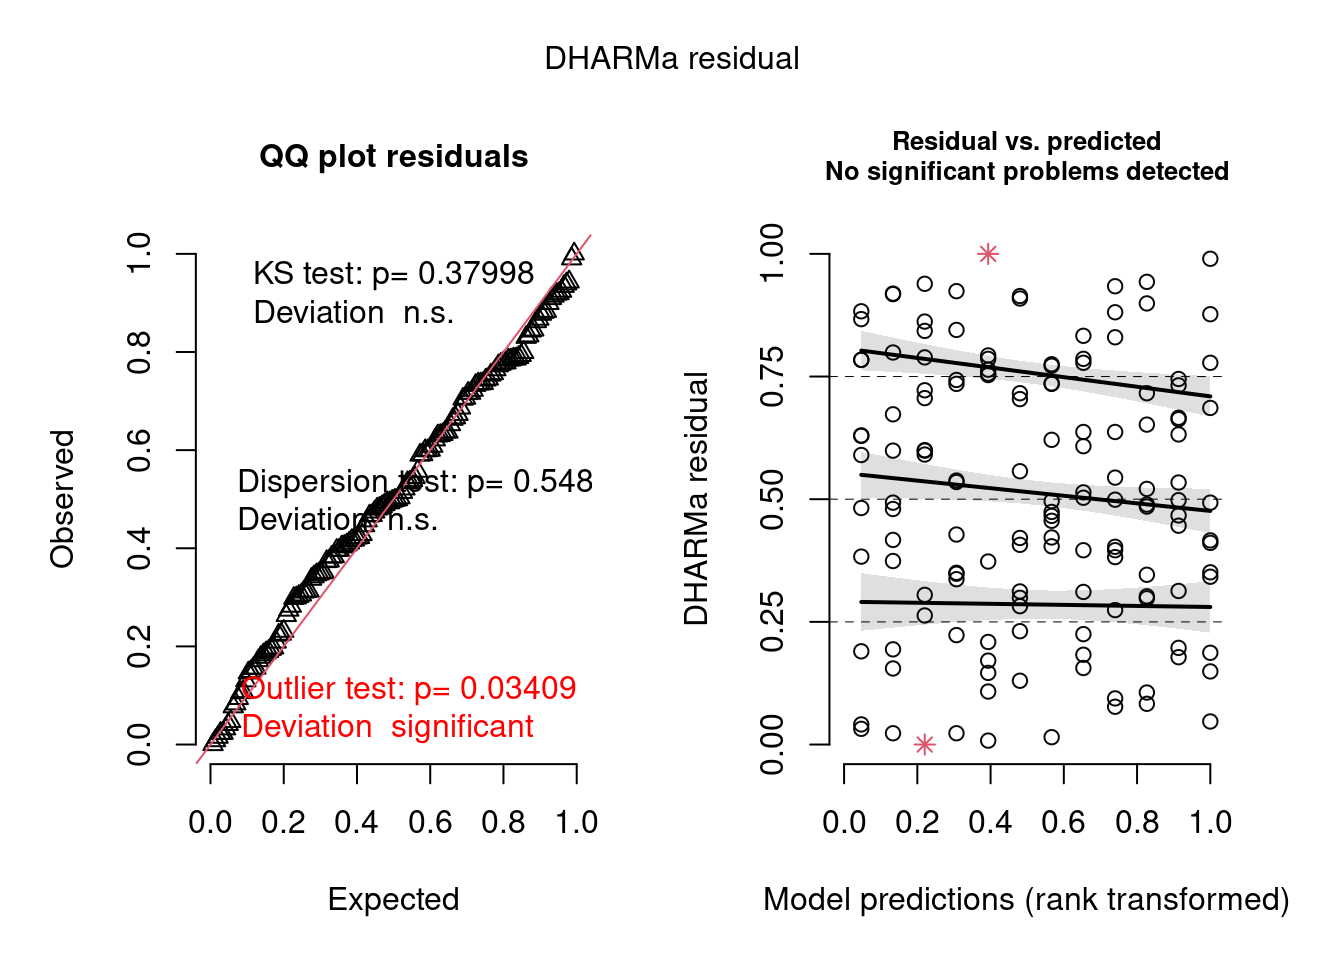

Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.041 0.077 0.008 0.313 0.396 0.023 0.231 0.106 0.047 0.023 0.015 0 0.083 0.149 0.197 0.225 0.155 0.19 0.274 0.108 ...

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: diff
                    Chisq Df Pr(>Chisq)
(Intercept)        0.7086  1     0.3999
treatment          1.8322  3     0.6080
location           1.0737  2     0.5846
treatment:location 4.3582  6     0.6283

In [ ]:
m8 <- glmmTMB(diff ~ treatment * location + (1|site) + (1|year),
              data = soil_diff)
simulateResiduals(m8, n = 1000, plot = TRUE) 


No interaction

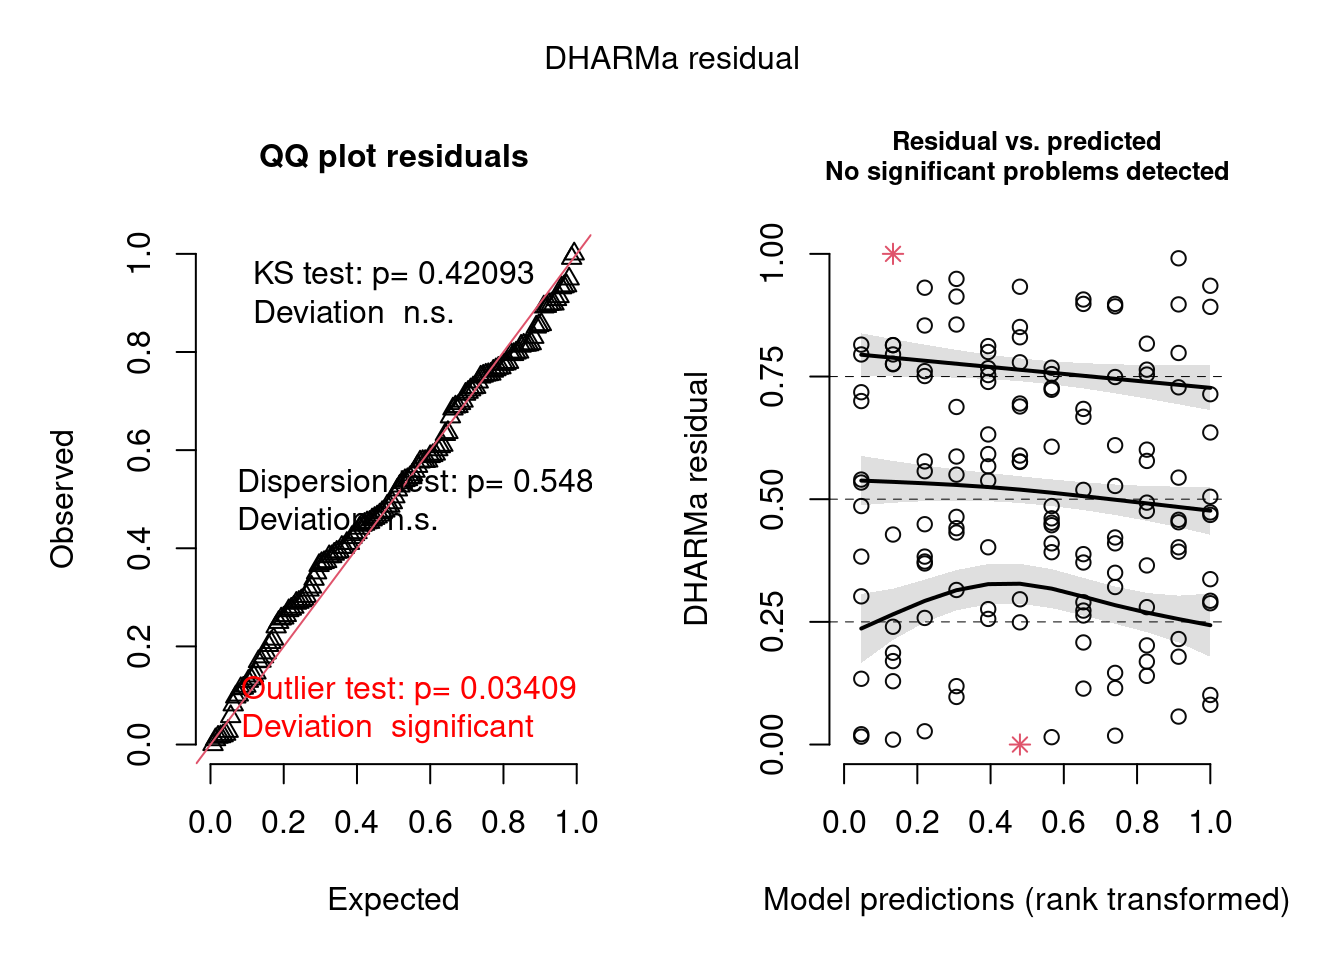

Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.021 0.097 0.01 0.402 0.365 0.018 0.208 0.101 0.057 0.027 0.015 0 0.081 0.179 0.276 0.202 0.115 0.134 0.315 0.129 ...

# Check for Multicollinearity

Low Correlation

      Term  VIF      VIF  CI Increased SE Tolerance
 treatment 1.00 [1.00, 1.00]         1.00      1.00
  location 1.00 [1.00, 1.00]         1.00      1.00

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: diff
             Chisq Df Pr(>Chisq)
(Intercept) 0.2055  1     0.6503
treatment   2.5923  3     0.4588
location    1.1674  2     0.5578

In [ ]:
m8 <- glmmTMB(diff ~ treatment + location + (1|site) + (1|year),
              data = soil_diff)
simulateResiduals(m8, n = 1000, plot = TRUE) 


### plots

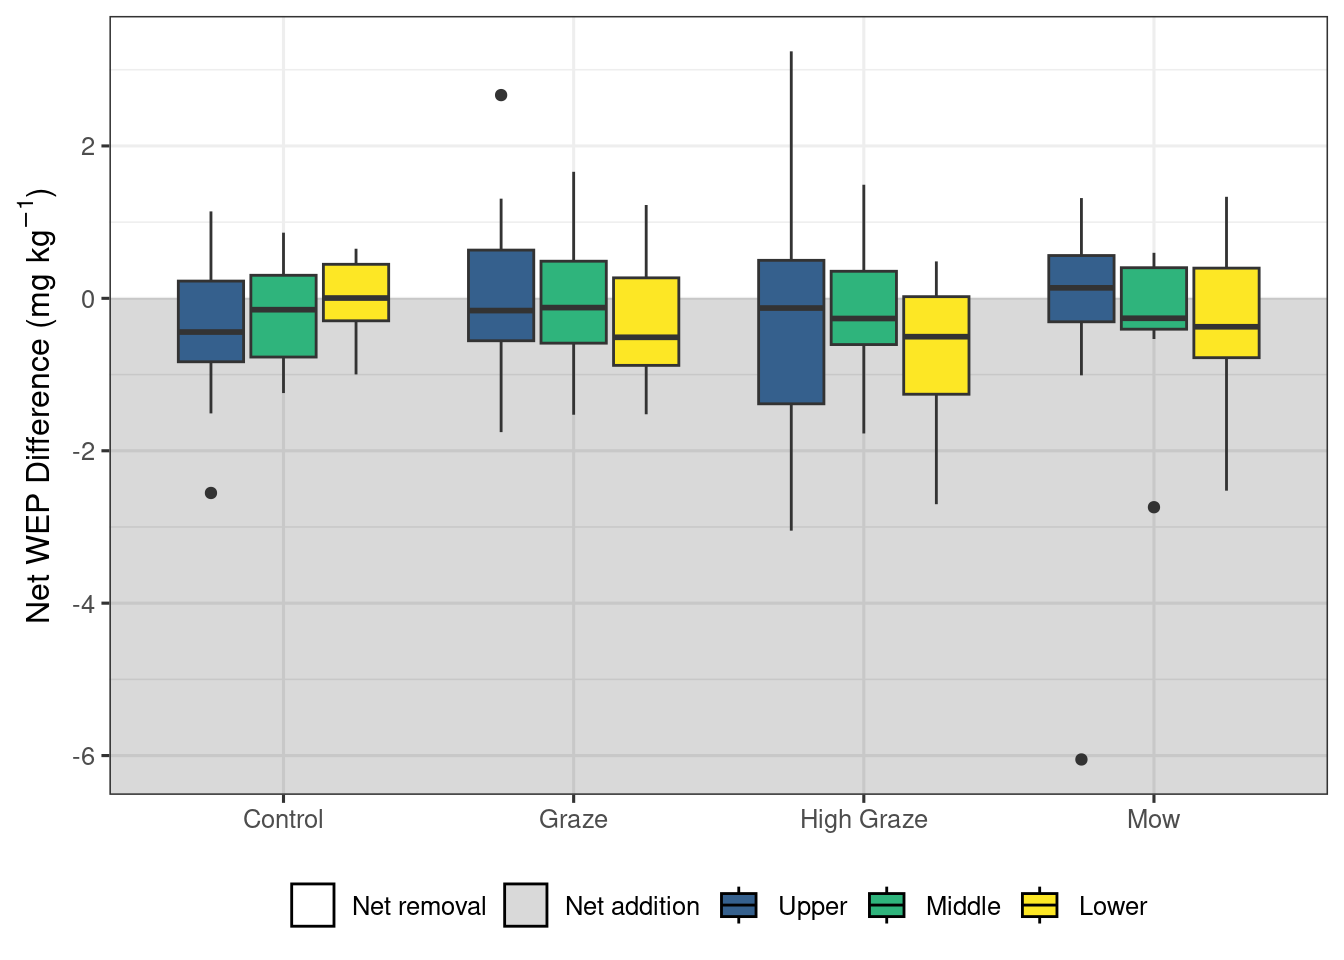

In [ ]:
#|
p2 <- ggplot(data = soil_diff) +
  theme_bw(base_size = 12) + 
  geom_rect(data = df, aes(xmin = x1, xmax = x2, ymin = y1, ymax = y2, fill = difference), alpha = 0.15) +
  #scale_fill_manual(values = c("white", "black")) +
  #ggnewscale::new_scale_fill() +
  geom_boxplot(aes(x = treatment, y = diff, fill = location)) +
  #scale_fill_viridis_d(name = "Location", begin = 0.3, end = 1) +
  scale_fill_manual(values = c("white", "black", "#35608DFF", "#2FB47CFF", "#FDE725FF")) +
  guides(fill = guide_legend(override.aes = list(colour = "black", size = 1))) +
  labs(y = expression(paste("Net WEP Difference (", mg~kg^{-1}, ")")), x = "Treatment") +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 0, vjust = 1, hjust = 0.5),
        legend.position = 'bottom', legend.title = element_blank())
p2
#ggsave(plot = p2, filename = "Figures/Soil_WEP.png", width = 150, height = 100, units = "mm", dpi = 600)
